# **HappyDB: Happy Moments Exploration - How is happiness expressed in words, and what topic does it have?**


## Yoojin Lee (yl4477)

## Introduction

The subjective emotion of happiness is expressed differently by each individual. Using HappyDB, I want to explore which words people with certain demographic characteristics use to express their happiness and through which topics. I also aim to investigate if there's any difference in the intensity of happiness between them.

## Dataset

HappyDB is a corpus of 100,000+ crowd-sourced happy moments. The goal of the corpus is to advance the state of the art of understanding the causes of happiness that can be gleaned from text.

HappyDB is a large scale collection of happy moments over 3 months on Amazon Mechanical Turk (MTurk.) For every task, we asked the MTurk workers to describe 3 happy moments in the past 24 hours (or past 3 months.)

### Let's get started!

#### Importing necessary packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import gensim # LDA import libraries
from gensim import corpora
from pprint import pprint
from gensim.models import CoherenceModel
# import pyLDAvis
# import pyLDAvis.gensim
from textblob import TextBlob
import seaborn as sns
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline

In [2]:
# Downloading NLTK datasets
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

# 1. Data preparation and basic analysis

## 1.1 Loading the HappyDB

In [3]:
urlfile = 'https://raw.githubusercontent.com/rit-public/HappyDB/master/happydb/data/cleaned_hm.csv'
hm_data = pd.read_csv(urlfile)
url= 'https://raw.githubusercontent.com/rit-public/HappyDB/master/happydb/data/demographic.csv'
df_demo = pd.read_csv(url)
# merge these two datasets
df = pd.merge(hm_data, df_demo, on='wid', validate='m:1')

In [4]:
df['predicted_category'].unique()

array(['affection', 'leisure', 'bonding', 'achievement',
       'enjoy_the_moment', 'exercise', 'nature'], dtype=object)

There exist 7 predicted categoreis already, but this is not enough to understand the happy moment.

## 1.2 Preliminary Cleaning of text

**For cleaned happy momoment, cleaning process is performed according to the criteria below:**

1. Convert it to a lowercase
2. Remove punctuation
    Remove characters like ".", ",", "!", "@", "#", etc...
3. Remove numbers
4. Remove leading and trailing space

In [5]:
df['cleaned_hm'] = df['cleaned_hm'].str.lower()
df['cleaned_hm'] = df['cleaned_hm'].str.replace('[^\w\s]', '')
df['cleaned_hm'] = df['cleaned_hm'].str.replace('\d+', '')
df['cleaned_hm'] = df['cleaned_hm'].str.strip()

<ipython-input-5-d94070610561>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['cleaned_hm'] = df['cleaned_hm'].str.replace('[^\w\s]', '')
<ipython-input-5-d94070610561>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['cleaned_hm'] = df['cleaned_hm'].str.replace('\d+', '')


In [6]:
stop_words = set(stopwords.words('english'))
custom_stopwords = ['day', 'today', 'yesterday', 'like', 'get', 'got', 'goes', 'went',
                 'one', 'two', 'make', 'made', 'see', 'saw', 'find', 'found', 'think',
                 'thought', 'year', 'last', 'month', 'months', 'first', 'time', 'morning',
                 'night', 'happy','happier', 'happiest', 'take', 'year', 'week', 'first time', 'days',
                 'last', 'week', 'past',
                 'able', 'really', 'come', 'afternoon', 'hour', 'going', 'friends',
                 'ago', 'lot']

stop_words.update(custom_stopwords)

words = [word for sublist in df['cleaned_hm'].str.split().tolist() for word in sublist if word not in stop_words]
# Counting the Occurrence of Each Words
word_counts = Counter(words)

Let's see top 10 words by counting the occurence of each words.

In [7]:
top_10_words = word_counts.most_common(10)
print(top_10_words)

[('new', 8862), ('work', 7832), ('good', 5839), ('friend', 5748), ('family', 4597), ('home', 4187), ('great', 3462), ('dinner', 3391), ('finally', 3333), ('long', 3284)]


In [8]:
df2 =df[~df['ground_truth_category'].isnull()]
df3 =df2[['ground_truth_category','cleaned_hm']]
df3.columns = ["label", "message"]
# Replace the values
df3.loc[df3['label'] == 'enjoy_the_moment', 'label'] = 'enjoy'
df3.loc[df3['label'] == 'achievement', 'label'] = 'achieve'

<ipython-input-8-156166cb0d8e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.loc[df3['label'] == 'enjoy_the_moment', 'label'] = 'enjoy'
<ipython-input-8-156166cb0d8e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.loc[df3['label'] == 'achievement', 'label'] = 'achieve'


Here's the box plot about counting categories by cleaned_hm column, but this is not enough to understand the happiness of individuals.

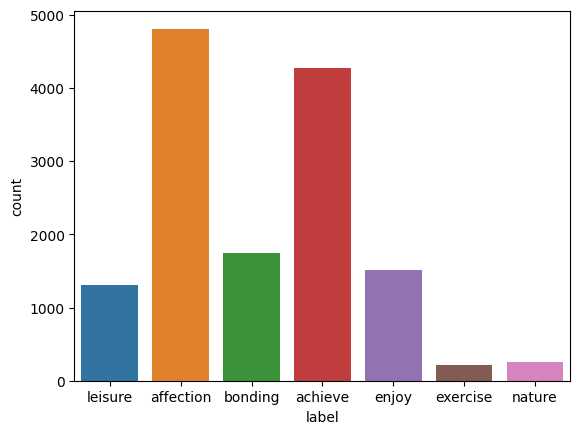

In [9]:
sns.countplot(x="label", data=df3);
plt.show()

# 2. Text Mining

## 2.1 WordClouds

### 2.1.1 Word Frequency Analysis

I aim to conduct a Word Frequency Analysis through text analysis. There are noise words that are not very informative, such as happy, yesterday, today... I am going to clean the word cloud by removing this noise. Additionally, I wanted to remove unnecessary words from the analysis and extract the base form of verbs.

In [10]:
def get_wordnet_pos(treebank_tag):
    """Convert treebank POS tagging to wordnet POS tagging."""
    from nltk.corpus import wordnet
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Tokenization
tokens = [word_tokenize(entry) for entry in df['cleaned_hm']]
all_tokens = [word for sublist in tokens for word in sublist]

# Removing stopwords
  # stopwords that don't hold any significant information for our data set
stop_words = set(stopwords.words('english'))
new_stopwords = ['day', 'today', 'yesterday', 'like', 'get', 'got', 'goes', 'went',
                 'one', 'two', 'make', 'made', 'see', 'saw', 'find', 'found', 'think',
                 'thought', 'year', 'last', 'month', 'months', 'first', 'time', 'morning',
                 'night', 'happy','happier', 'happiest', 'take', 'year', 'week', 'first time', 'days',
                 'last', 'week', 'past',
                 'able', 'really', 'come', 'afternoon', 'hour', 'going', 'friends',
                 'ago', 'lot']
stop_words = stop_words.union(new_stopwords)
filtered_tokens = [word for word in all_tokens if word not in stop_words]

# Lemmatization
lemmatizer = WordNetLemmatizer()
tags = pos_tag(filtered_tokens)
lemmatized_tokens = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in tags]

# Word frequency
freq_dist = nltk.FreqDist(lemmatized_tokens)
print(freq_dist.most_common(10))

[('work', 9889), ('new', 8904), ('good', 6192), ('friend', 5749), ('family', 4674), ('home', 4211), ('watch', 4052), ('come', 3930), ('buy', 3838), ('play', 3648)]


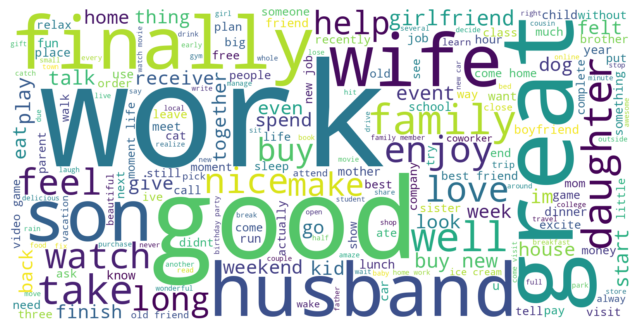

In [11]:
# Generating word cloud
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(' '.join(lemmatized_tokens))

# Displaying the WordCloud
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### 2.1.2 Associated Word Analysis

Through the above wordcloud, I examined which words appeared frequently. Now, I aim to pick the **top 5 frequently appearing noun keywords**, and using the co-occurrence frequency of words related to these keywords, I want to create a word cloud.

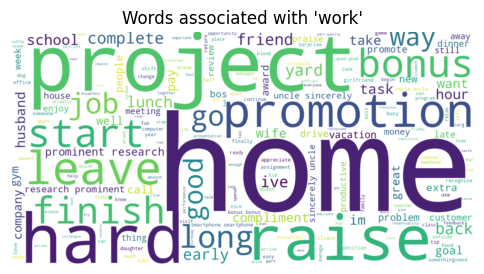

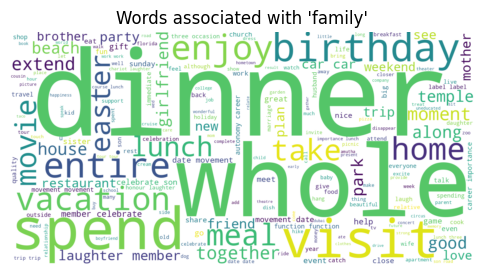

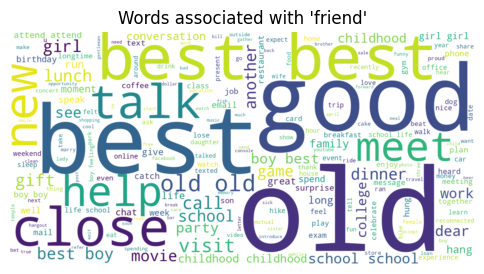

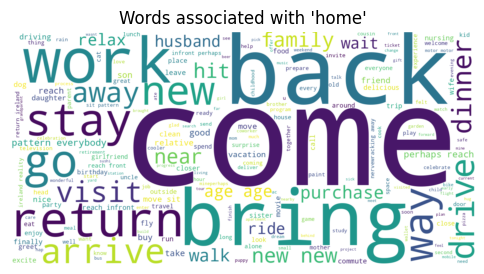

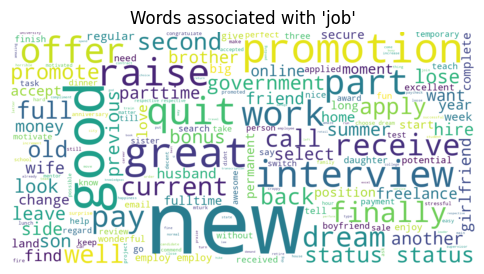

In [12]:
# Filter nouns (NN)
nouns = [word for word, tag in tags if tag.startswith('NN')]

# Frequency distribution of nouns
noun_freq_dist = nltk.FreqDist(nouns)

top_nouns = [item[0] for item in noun_freq_dist.most_common(5)]

# Generating word clouds for each keyword
for keyword in top_nouns:
    associated_words = [word for word, next_word in zip(lemmatized_tokens[:-1], lemmatized_tokens[1:]) if next_word == keyword or word == keyword]
    associated_words = [word for word in associated_words if word != keyword] + [keyword]

    wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(' '.join(associated_words))
    plt.figure(figsize=(6, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Words associated with '{keyword}'")
    plt.axis('off')
    plt.show()

## 2.2 Sentiment Analysis

Since we are using the HappyDB, I will perform **Sentiment Analysis** on each sentence about the happy moment. Since we have demographic information, I was curious to see if there are any differences in **emotional intensity** based on the demographic information, and I am going to analyze it.

In [13]:
! pip install textblob

In [14]:
import nltk

In [15]:
# download the corpora used by TextBlob:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

In [16]:
# Get sentiment polarity for each happy moment
df['sentiment'] = df['cleaned_hm'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['subjectivity'] = df['cleaned_hm'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [17]:
# Display some basic stats
avg_sentiment = df['sentiment'].mean()
avg_subjectivity = df['subjectivity'].mean()
print(f"Average Polarity: {avg_sentiment:.2f}")
print(f"Average Subjectivity: {avg_subjectivity:.2f}")

Average Polarity: 0.23
Average Subjectivity: 0.43


In [18]:
# We can also categorize sentiments as positive, negative, or neutral based on polarity
def categorize_sentiment(polarity):
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

df['category_sentiment'] = df['sentiment'].apply(categorize_sentiment)

print(df['category_sentiment'].value_counts())

positive    61973
neutral     29800
negative     8762
Name: category_sentiment, dtype: int64


Let's visualize the sentiment distribution with histogram:

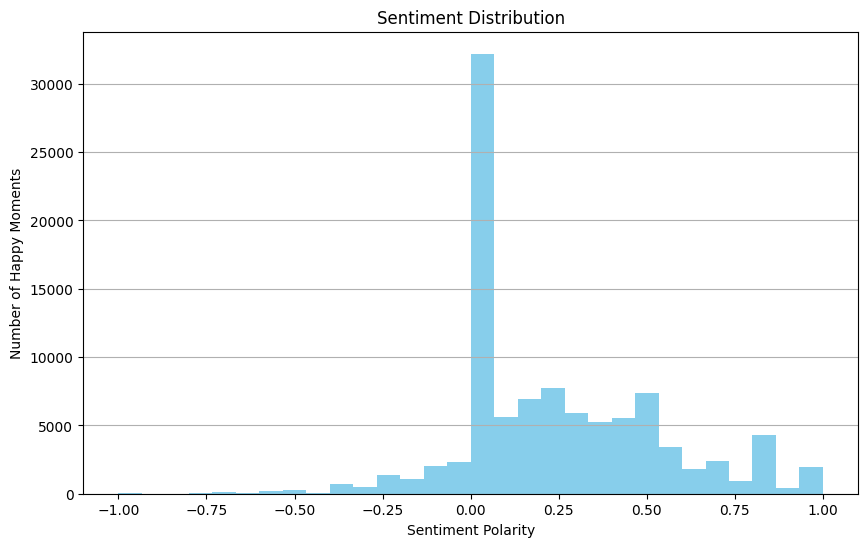

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(df['sentiment'], bins=30, color='skyblue')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Number of Happy Moments')
plt.grid(axis='y')
plt.show()

To analyze emotional intensity, we can make use of the **VADER** (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis tool which is specifically attuned to sentiments expressed in social media.

It is a lexicon and rule-based sentiment analysis tool that is used to determine polarity (positive, negative, neutral) and also intensity (strength) of the sentiment.

In [20]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/126.0 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━ 112.6/126.0 kB 3.5 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.7 MB/s eta 0:00:00


I am going to use **VADER** to analyze emotional intensity.

In [21]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in df['cleaned_hm']]

This compound score can be used as emotional intensity metric. This ranges from -1 (most extreme negative) to 1 (most extreme positive)

With this, let's analyze Emotional Intensity Based on Demographic information.

### By Gender:

In [22]:
genders = df['gender'].unique()
for gender in genders:
    subset = df[df['gender'] == gender]
    print(f"Average emotional intensity for {gender}: {subset['compound'].mean()}")

Average emotional intensity for m: 0.3609397365227942
Average emotional intensity for f: 0.3898644369963632
Average emotional intensity for nan: nan
Average emotional intensity for o: 0.3473816355810617


Average emotional intensity for m: 0.3609397365227942
Average emotional intensity for f: 0.3898644369963632
Average emotional intensity for o: 0.3473816355810617


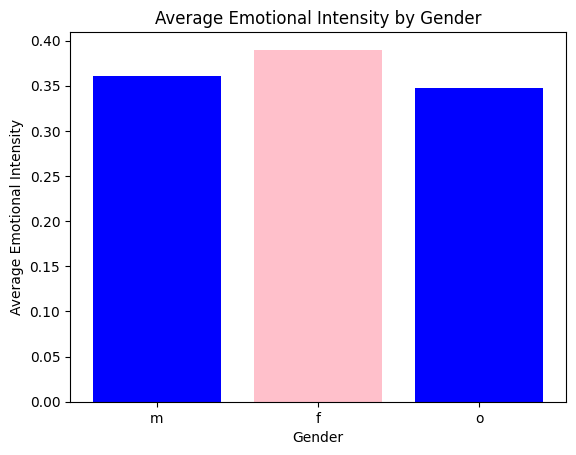

In [23]:
# Exclude rows with missing gender values
df_cleaned = df.dropna(subset=['gender'])

genders = df_cleaned['gender'].unique()
gender_intensities = []

for gender in genders:
    subset = df_cleaned[df_cleaned['gender'] == gender]
    avg_intensity = subset['compound'].mean()
    gender_intensities.append(avg_intensity)
    print(f"Average emotional intensity for {gender}: {avg_intensity}")

plt.bar(genders, gender_intensities, color=['blue', 'pink'])
plt.xlabel('Gender')
plt.ylabel('Average Emotional Intensity')
plt.title('Average Emotional Intensity by Gender')
plt.show()


### By Parenthood:

Average emotional intensity for parenthood value n: 0.36396663111081934
Average emotional intensity for parenthood value y: 0.38664613613360327


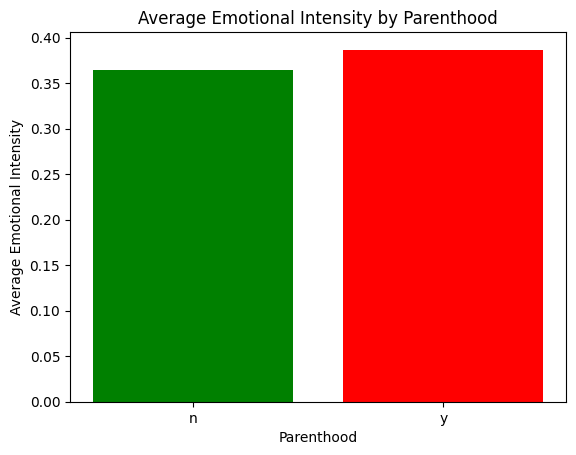

In [24]:
# Exclude rows with missing parenthood values
df_cleaned = df.dropna(subset=['parenthood'])

parenthood_values = df_cleaned['parenthood'].unique()
parenthood_intensities = []

for value in parenthood_values:
    subset = df_cleaned[df_cleaned['parenthood'] == value]
    avg_intensity = subset['compound'].mean()
    parenthood_intensities.append(avg_intensity)
    print(f"Average emotional intensity for parenthood value {value}: {avg_intensity}")

plt.bar(parenthood_values, parenthood_intensities, color=['green', 'red'])
plt.xlabel('Parenthood')
plt.ylabel('Average Emotional Intensity')
plt.title('Average Emotional Intensity by Parenthood')
plt.show()


### By Country:

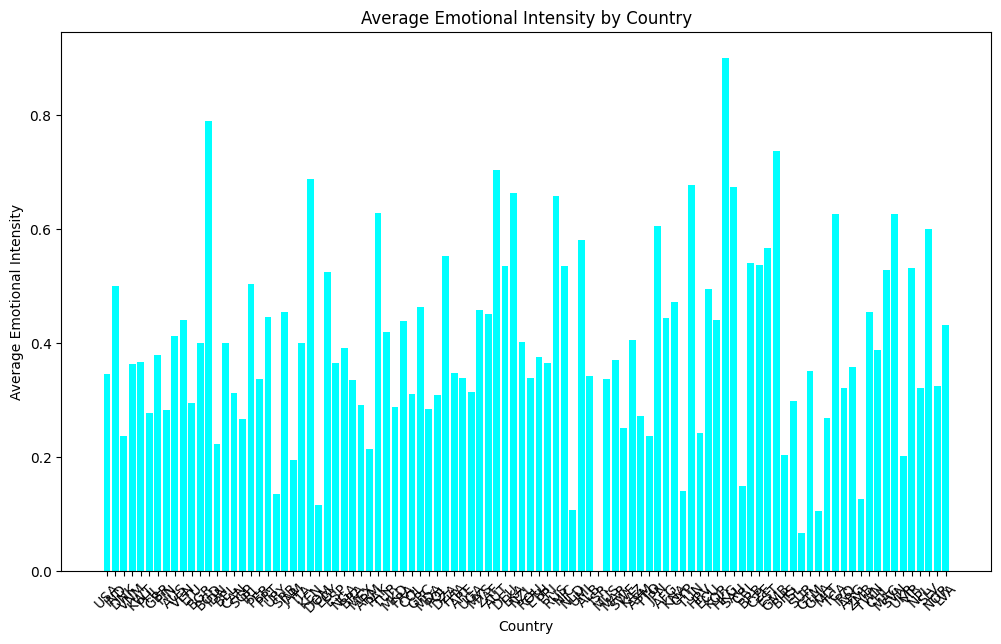

In [25]:
countries = df['country'].dropna().unique()
country_intensities = [df[df['country'] == country]['compound'].mean() for country in countries]

plt.figure(figsize=(12,7))
plt.bar(countries, country_intensities, color='cyan')
plt.xlabel('Country')
plt.ylabel('Average Emotional Intensity')
plt.title('Average Emotional Intensity by Country')
plt.xticks(rotation=45)
plt.show()


This is hard to interpret, so I'm going to show Average Emotional Intensity by Country with world map.

In [26]:
import plotly.express as px

# Create a DataFrame to hold country data
df_country = pd.DataFrame({
    'country': countries,
    'intensity': country_intensities
})

# Draw the choropleth map
fig = px.choropleth(df_country,
                    locations="country",
                    locationmode='ISO-3',   # Using ISO-3 for three-letter country codes
                    color="intensity",
                    hover_name="country",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title='Average Emotional Intensity by Country'
)

fig.show()


### By Marital Status:

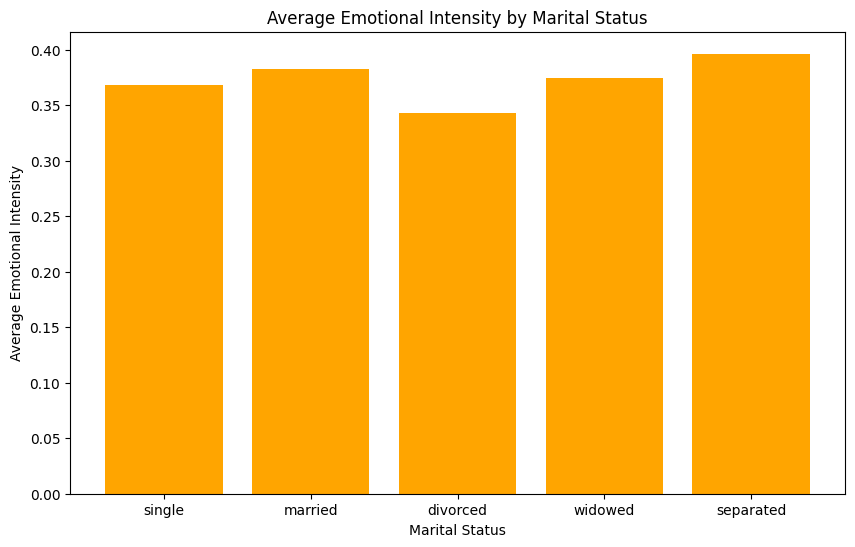

In [27]:
marital_statuses = df['marital'].dropna().unique()
marital_intensities = [df[df['marital'] == status]['compound'].mean() for status in marital_statuses]

plt.figure(figsize=(10,6))
plt.bar(marital_statuses, marital_intensities, color='orange')
plt.xlabel('Marital Status')
plt.ylabel('Average Emotional Intensity')
plt.title('Average Emotional Intensity by Marital Status')
plt.show()


From above, it is hard to figure out significant factor by analyzing sentiment, so I decided to do Topic Modeling to gain deeper understanding.

## 2.4 LDA Topic Modeling

Although we already know 7 categores of topics, but I am trying to get more detailed insight to figure out the words expressed about happiness by doing LDA Topic Modeling.

In [28]:
! pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 24.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.1.1 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.26.0 which is incompatible.
tensorflow 2.13.0 

In [29]:
import pyLDAvis
import pyLDAvis.gensim

In [30]:
## remove stopwords while retain document structure
filtered_tokens = [[word for word in doc if word not in stop_words] for doc in tokens]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



**Preparing data for LDA:**

Since I've already tokenized and cleaned the data,
I just created a dictionary and a corpus for the LDA model.

In [31]:
dictionary = corpora.Dictionary(filtered_tokens)
corpus = [dictionary.doc2bow(text) for text in filtered_tokens]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Let's build the LDA model. I'm going to build a model with **5 topics**.

In [ ]:
# Build the LDA model - building a model with 5 topics
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=5, random_state=42, chunksize=100, passes=10, per_word_topics=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Before visualizing the LDA model with tools, let's breifly view the topics!

In [ ]:
pprint(lda_model.print_topics())

In [ ]:
# revert pandas version to visualize LDA

In [ ]:
! pip install pandas==1.5.3

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.079229  0.345564       1        1  23.137897
0      0.149627  0.047107       2        1  21.361559
4     -0.142361 -0.244358       3        1  19.617991
1      0.319739 -0.090228       4        1  18.835000
3     -0.247776 -0.058086       5        1  17.047553, topic_info=         Term          Freq         Total Category  logprob  loglift
92       home   5498.000000   5498.000000  Default  30.0000  30.0000
45       work  10187.000000  10187.000000  Default  29.0000  29.0000
393  daughter   4158.000000   4158.000000  Default  28.0000  28.0000
10        new   6782.000000   6782.000000  Default  27.0000  27.0000
38        son   4404.000000   4404.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
10        new   4240.089013   6782.366440   Topic5  -3.3944   1.2994
61    brother    921.538488   1152.845516   Topic5  -4.9207   1.5452
257       old   1765.390441   3662.806513   Topic5  -4.2706   1.0393
166      gave   1097.920248   1853.463998   Topic5  -4.7456   1.2455
624      said    913.238653   1843.808658   Topic5  -4.9298   1.0666

[220 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
836       3  0.998745  actually
409       1  0.999466    always
207       4  0.998269   amazing
27        2  0.999229   another
548       5  0.999586     asked
...     ...       ...       ...
45        2  0.422777      work
45        4  0.577085      work
68        4  0.999604   working
547       1  0.404298     would
547       2  0.595350     would

[217 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 5, 2, 4])

## 2.5. Visualizing Topic wizard

Although PyLDAvis provided great visual investigation of topic models, but I wanted to investigate the complex relations between topics.
So, I've used Topicwizard to create more advanced topic modeling visualization wordk.

In [ ]:
! pip install topic-wizard

In [ ]:
import topicwizard

In [ ]:
from sklearn.decomposition import NMF

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
docs_for_topicwizard = [' '.join(doc) for doc in filtered_tokens]

# Convert the stop_words set to a list
stop_words_list = list(stop_words)

# Set up the CountVectorizer with your stopwords and other parameters
vectorizer = CountVectorizer(min_df=10, max_df=0.5, stop_words=stop_words_list)

# Define the NMF model with 5 components (topics) as per your LDA example
topic_model = NMF(n_components=5)

# Set up the pipeline
topic_pipeline = Pipeline([
    ("vectorizer", vectorizer),
    ("topic_model", topic_model),
])

topic_pipeline.fit(docs_for_topicwizard)

# Visualize using topicwizard
topicwizard.visualize(pipeline=topic_pipeline, corpus=docs_for_topicwizard)

# Save the topic data for further use (optional)
# topicwizard.save(topic_pipeline, "topic_data.joblib")

In [ ]:
from IPython.display import IFrame

In [ ]:
topicwizard.load(filename="topic_data.joblib")

Preparing data
Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/



INFO:topicwizard.app:Dash is running on http://127.0.0.1:8050/



 * Serving Flask app 'topicwizard.app'
 * Debug mode: off


Address already in use
Port 8050 is in use by another program. Either identify and stop that program, or start the server with a different port.


Open in browser:


<IPython.core.display.Javascript object>

<Thread(Thread-153 (_run_silent), stopped 132917242099264)>

By clicking above *'Click this link to open topicwizard'*, you can see the result like below images:

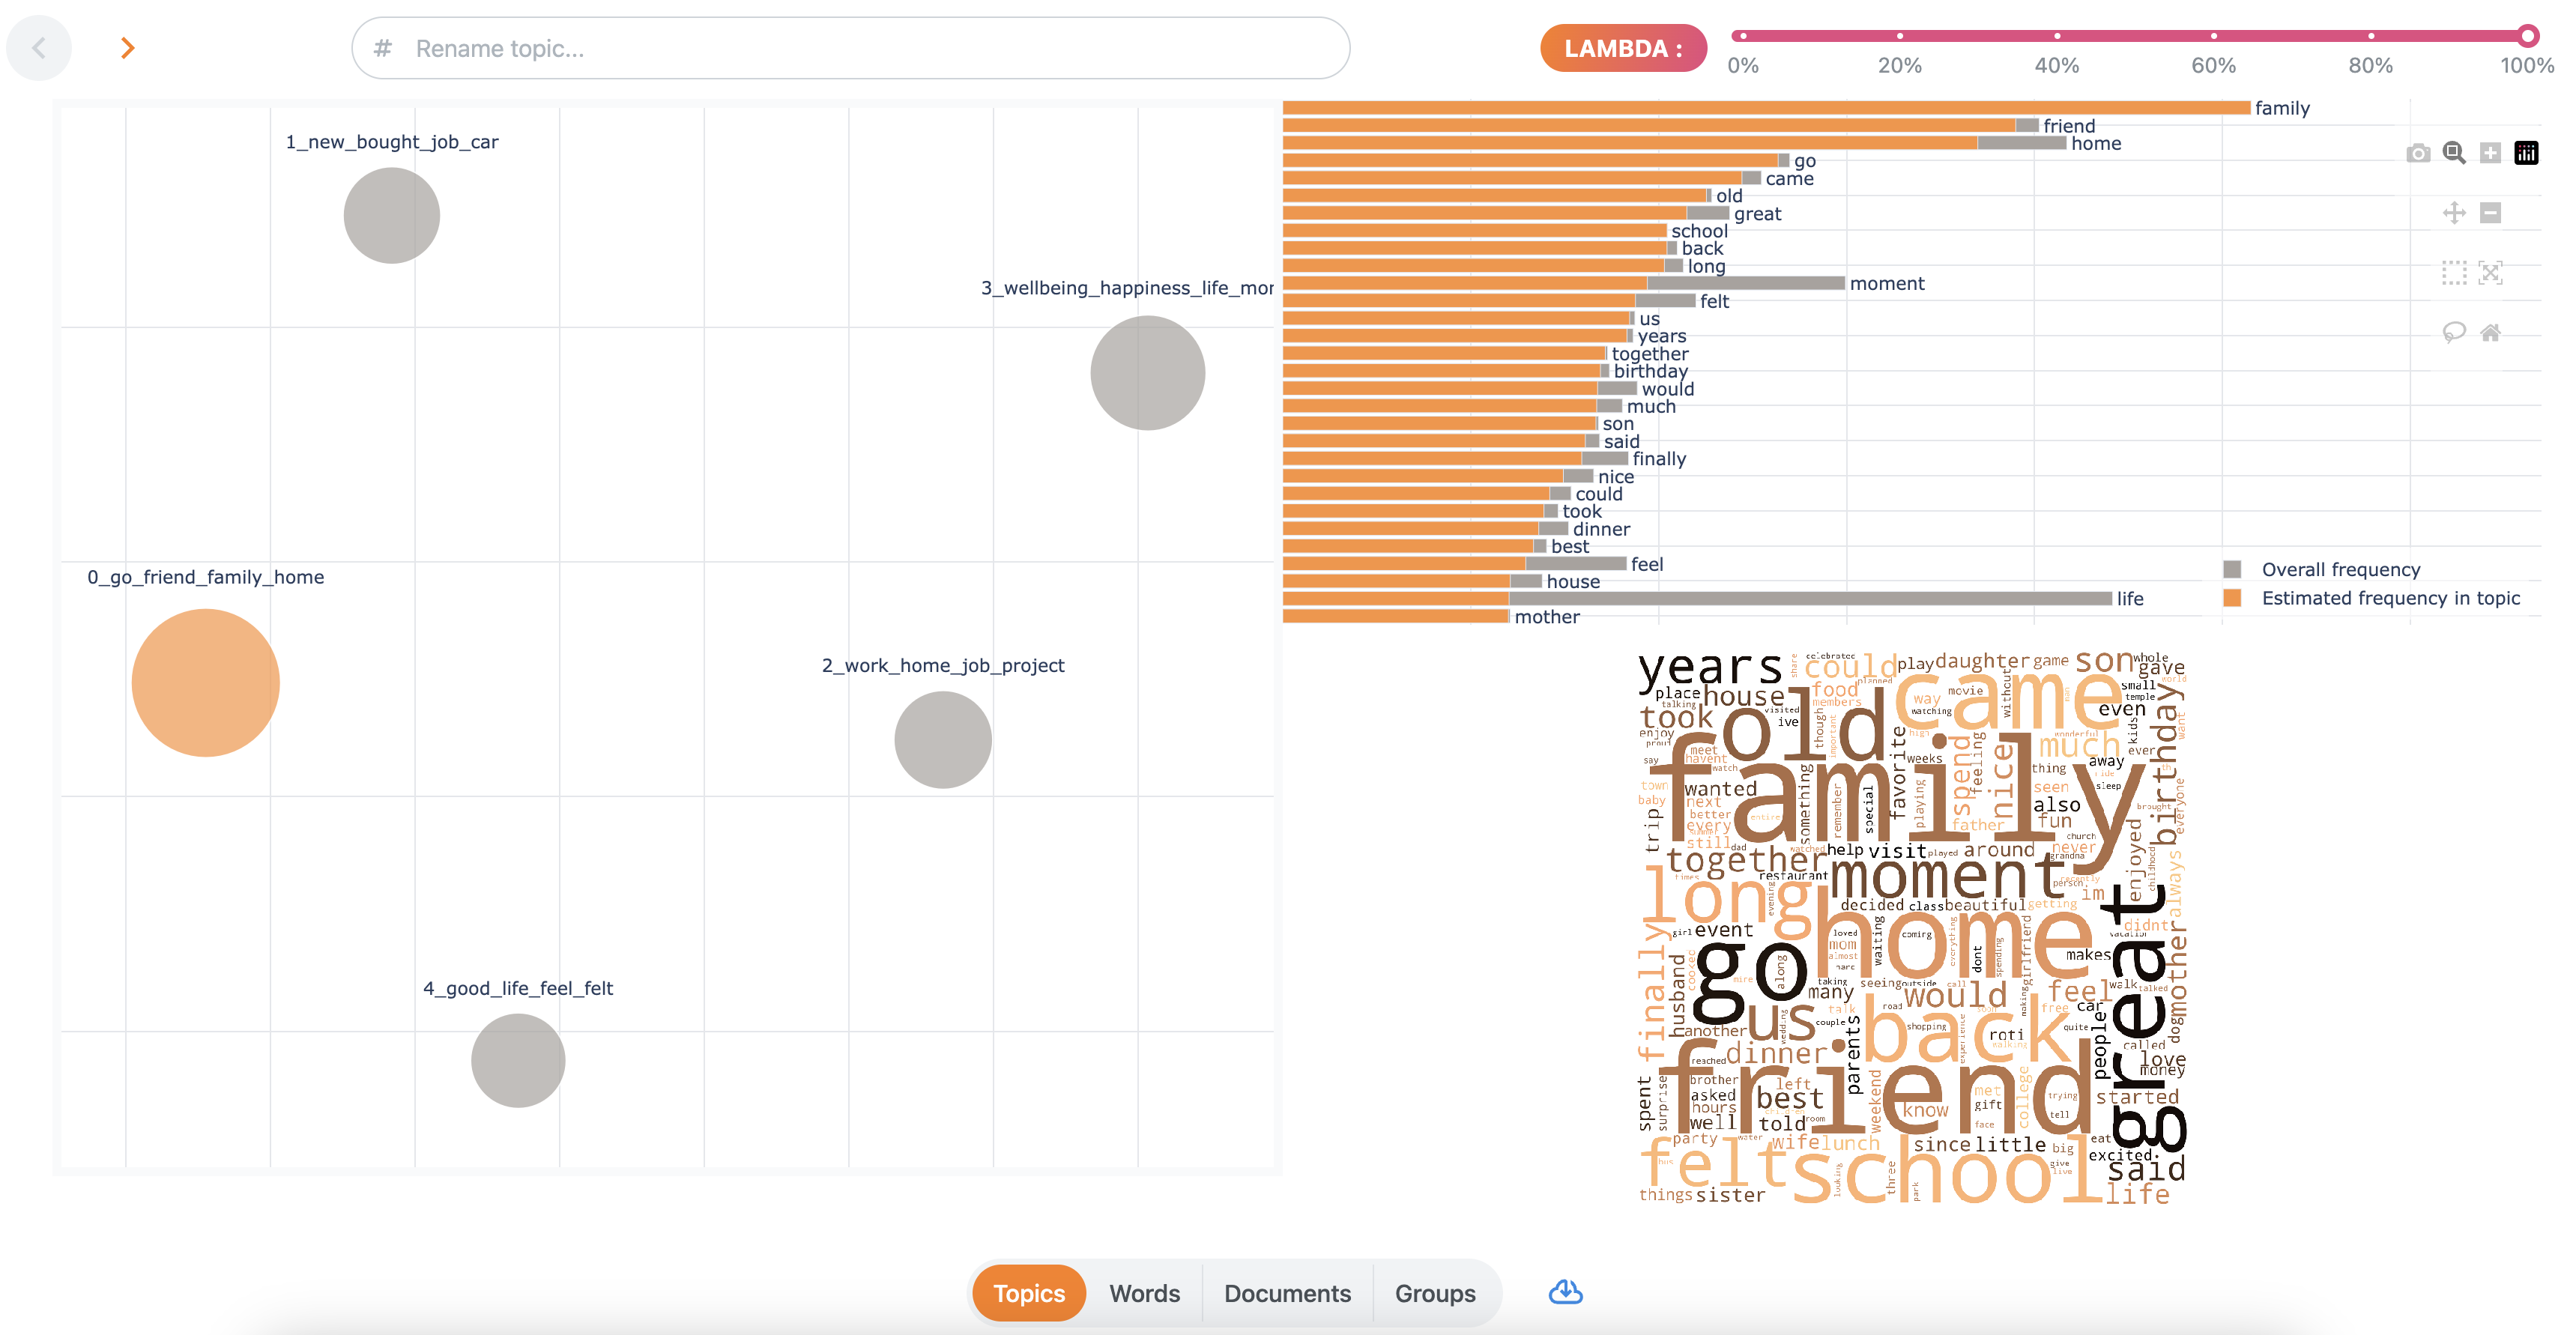

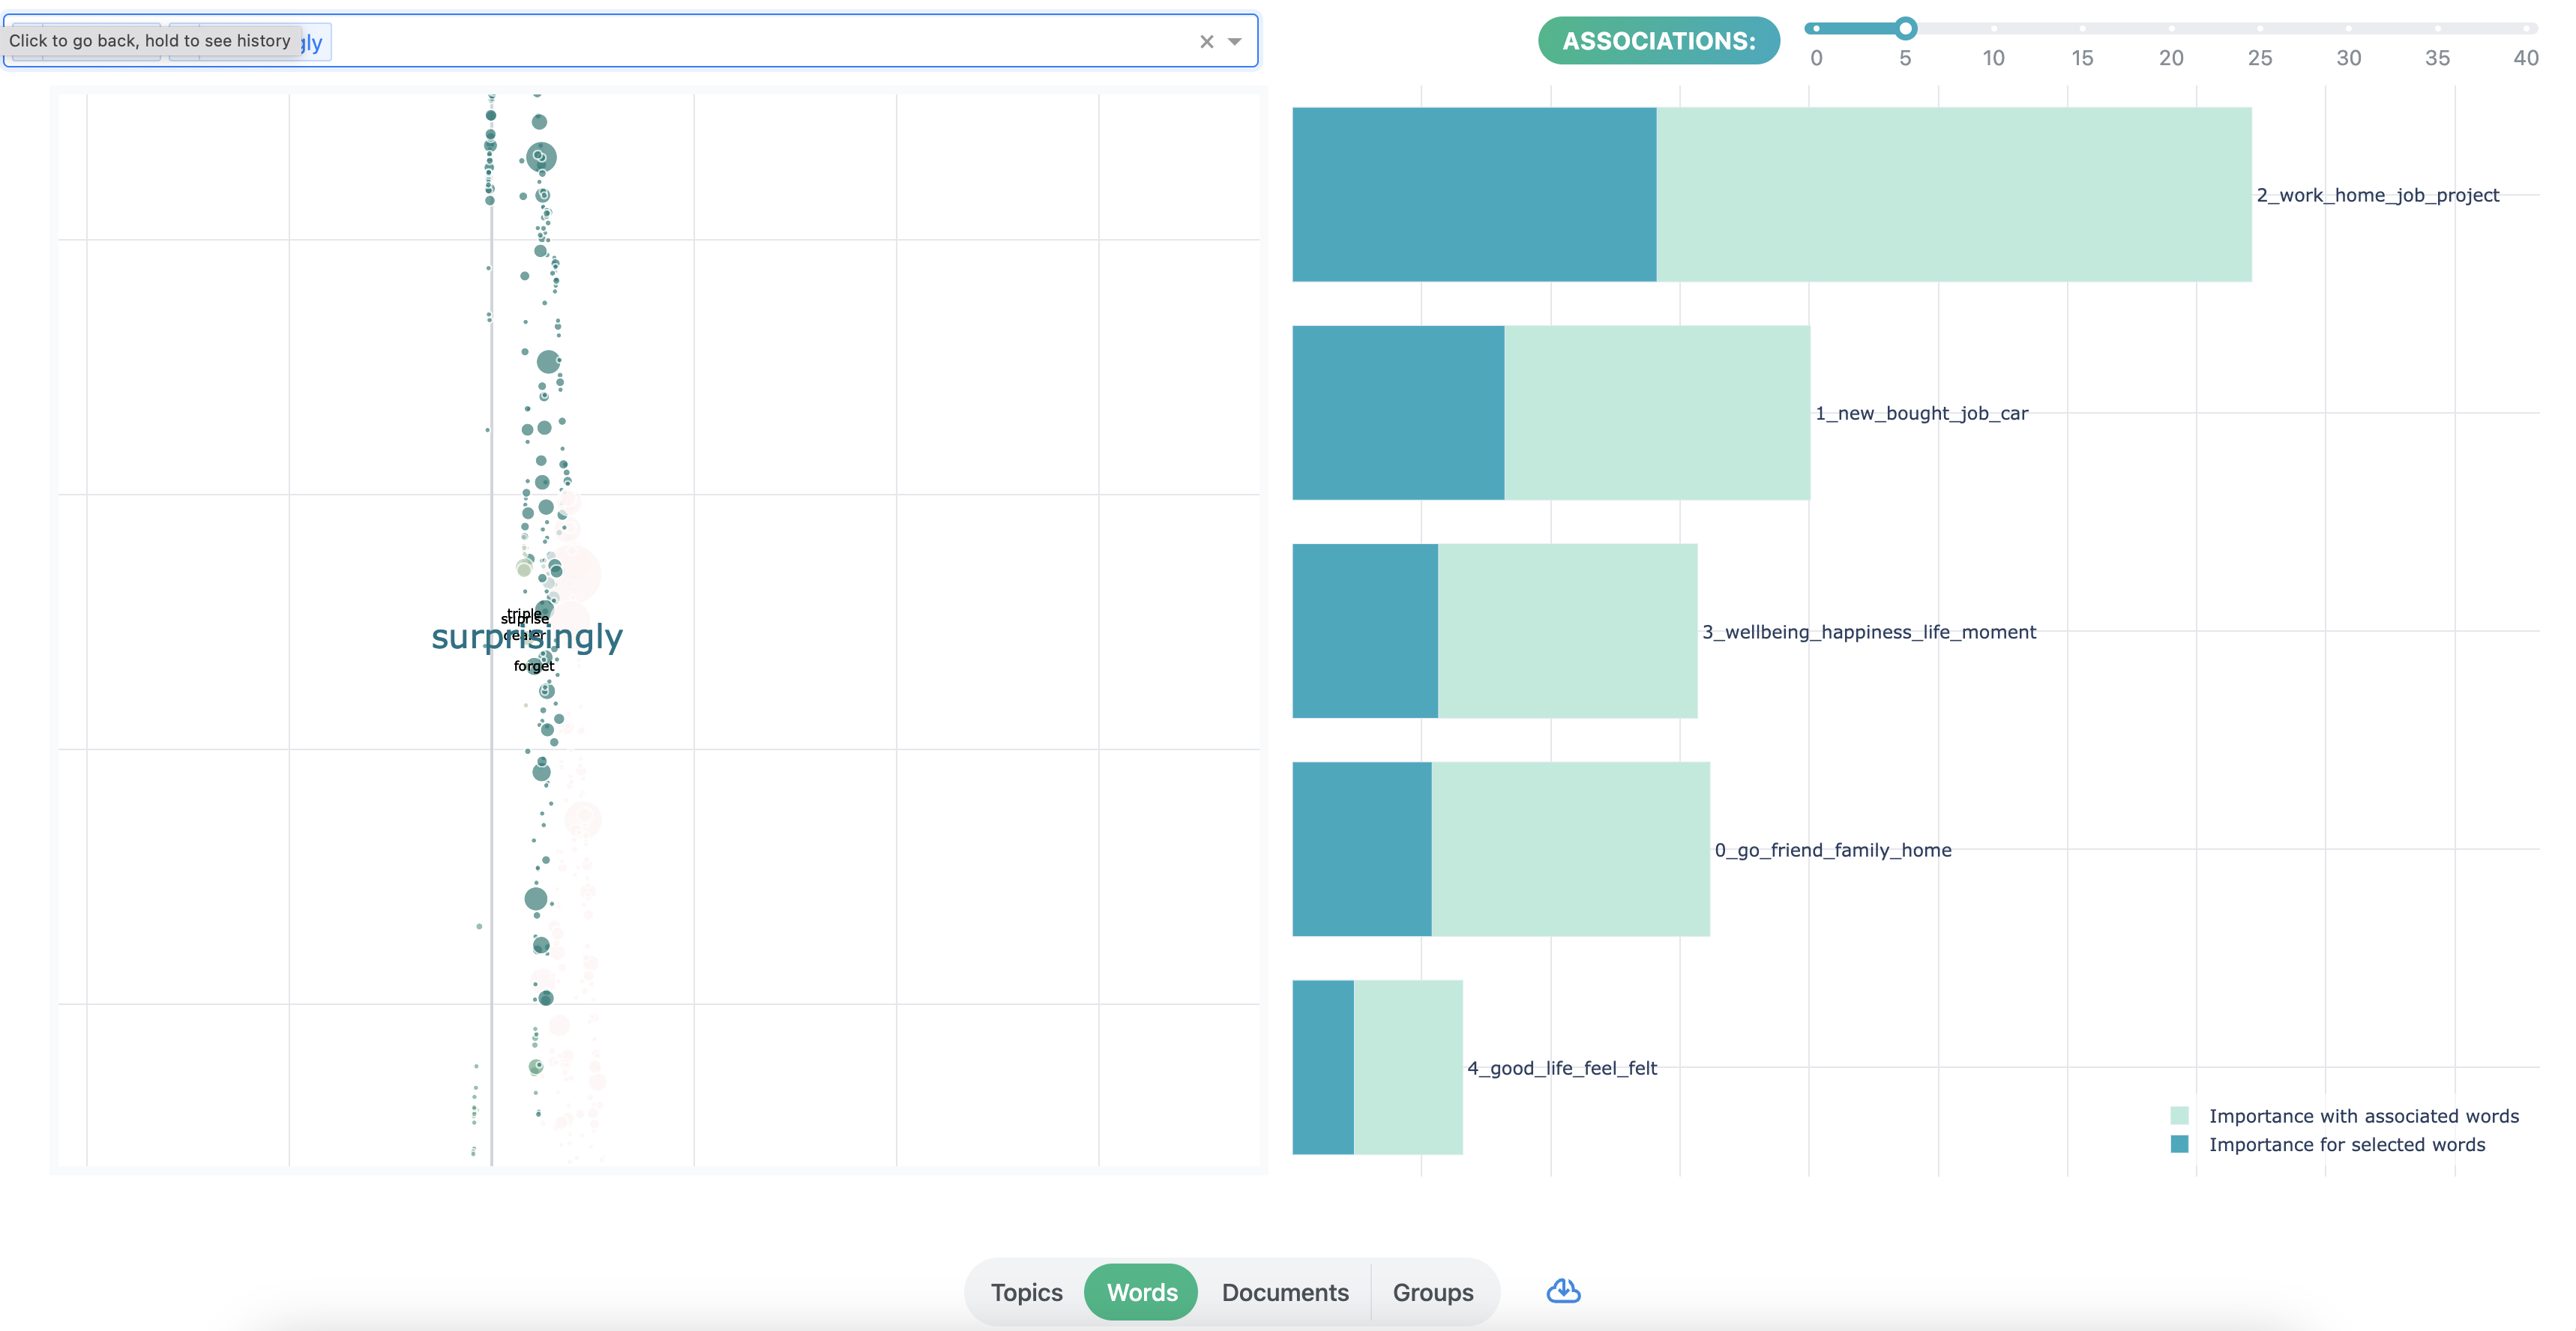

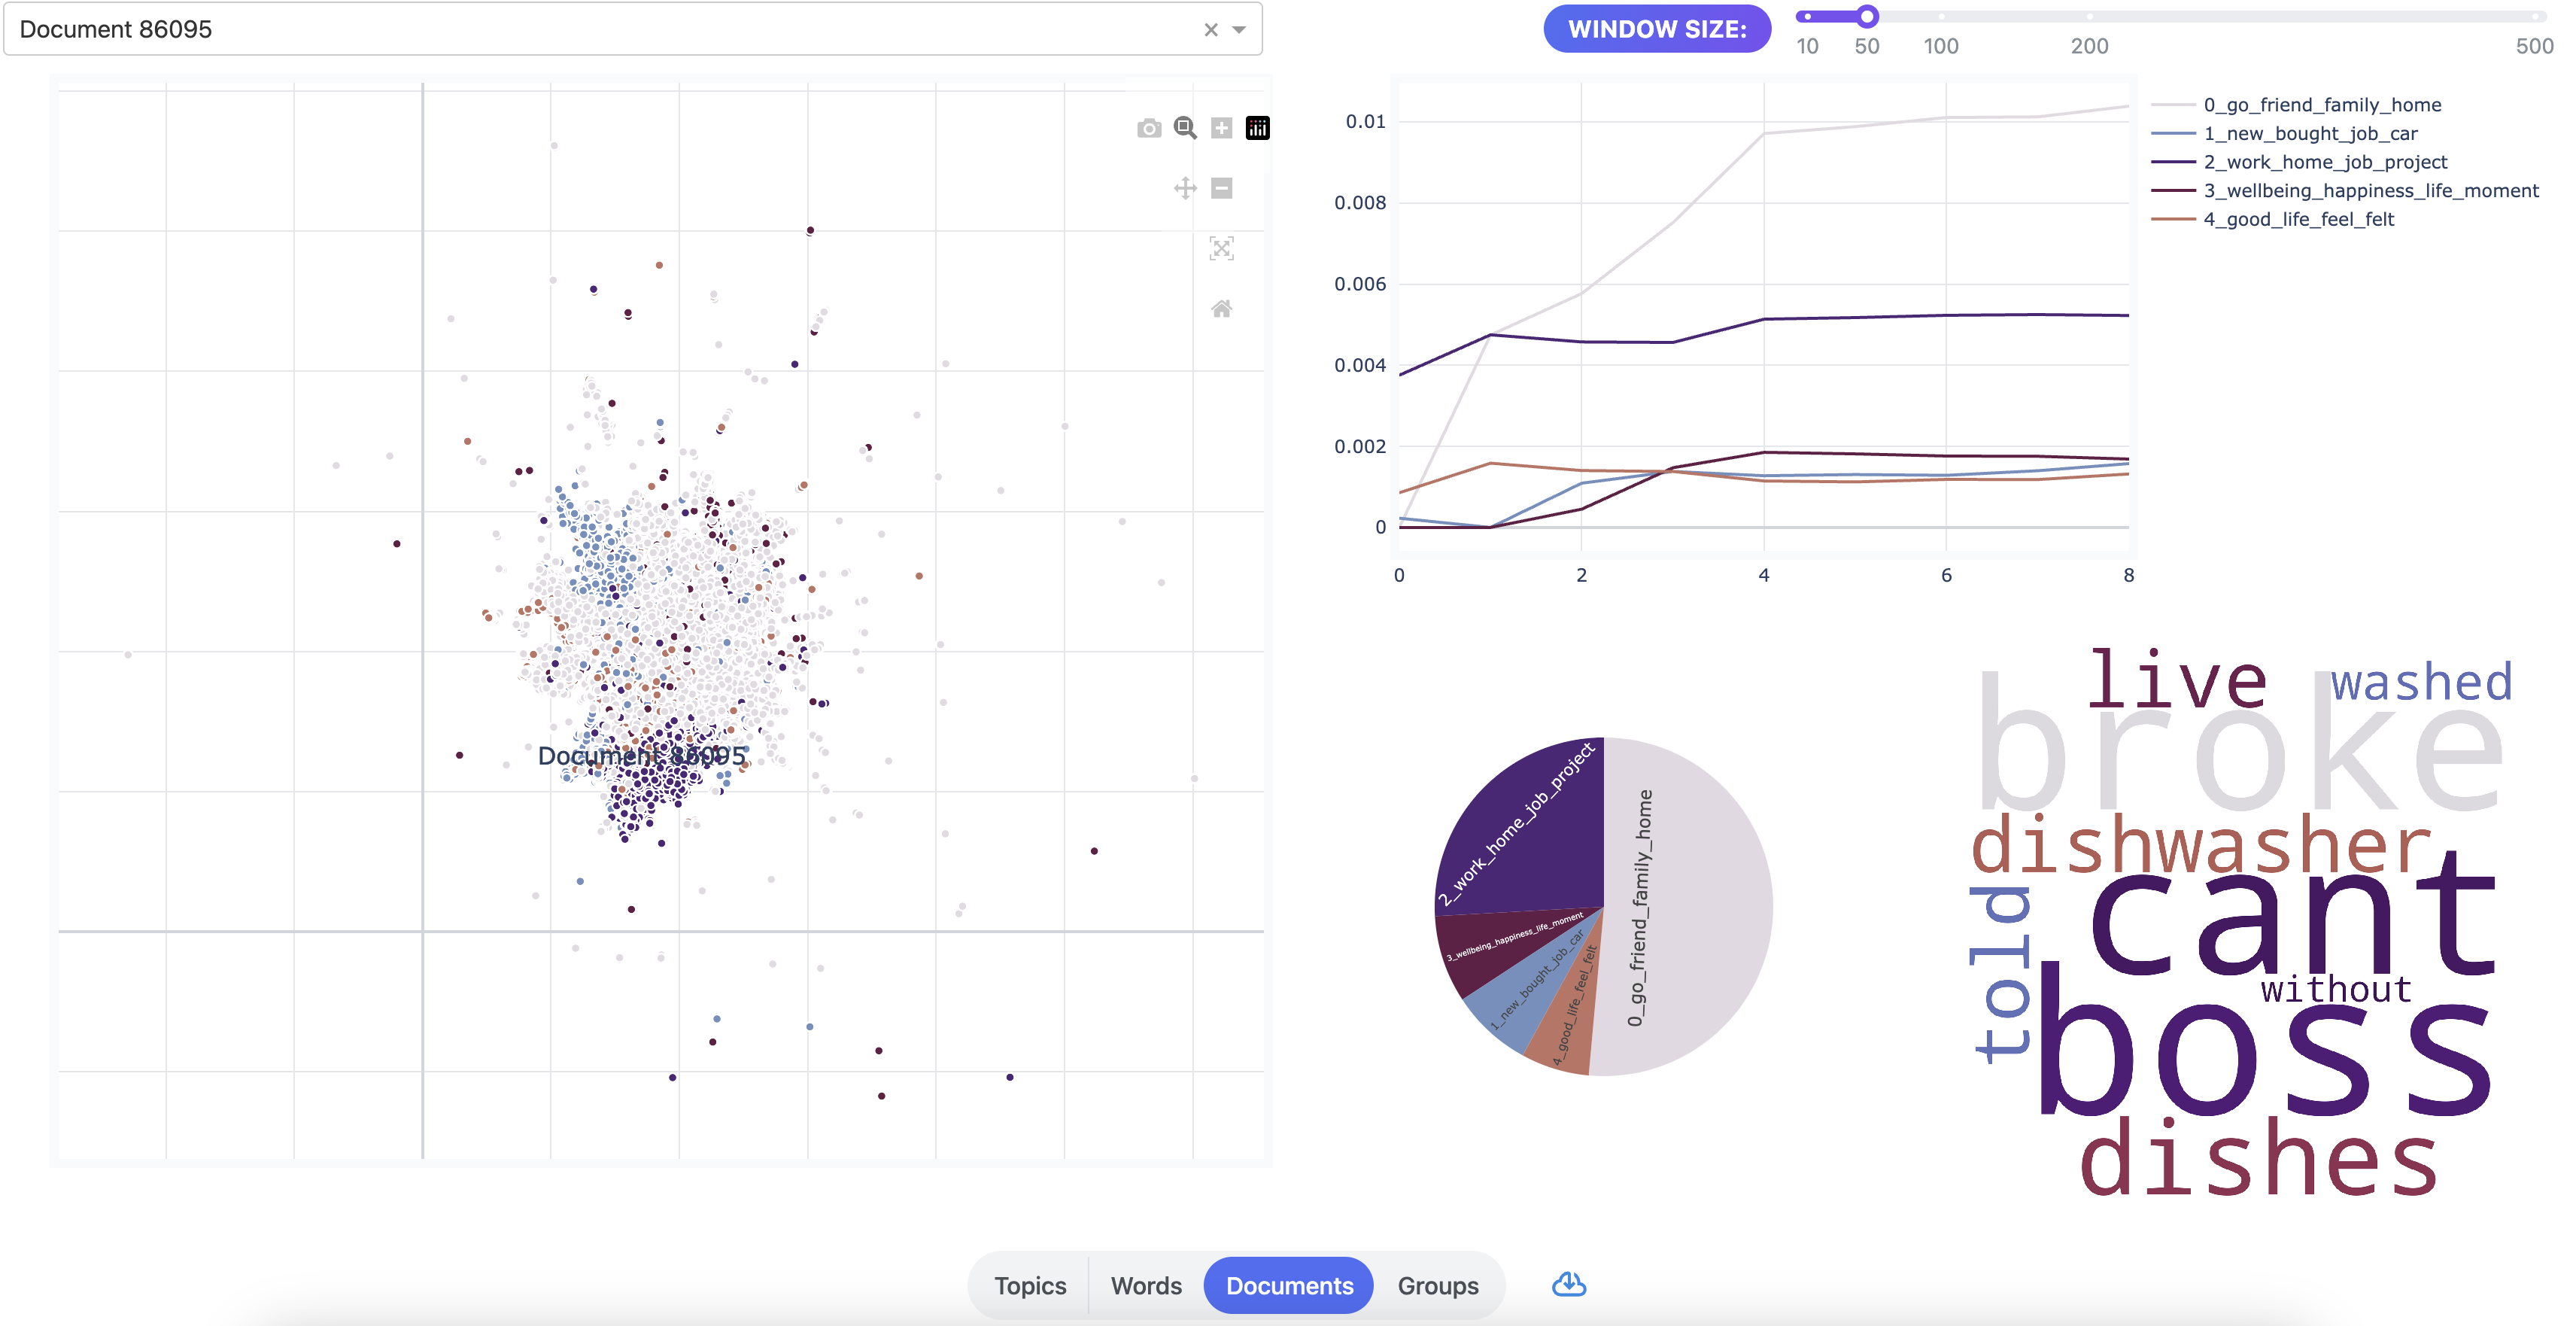

## Conclusion

The analysis of HappyDB provided an opportunity to approach the complex nature of happiness based on demographic information. Although no significant differences were found in the process, analyzing frequently appearing words through a wordcloud and seeing which associated words came up allowed us to see which keywords were often expressed together with happy moments. Additionally, through topic modeling, we could identify which words frequently appeared based on specific topics, and determine the keywords associated with those topics.